# Регрессия DecisionTreeRegressor

In [1]:
from mylib import base, dataset
from mylib.model_regression import ModelRegression

from dotenv import dotenv_values
from pathlib import Path
from pprint import pprint, pformat
import joblib

import pandas as pd
import numpy as np

import plotly.express as plotly_px
import plotly.graph_objects as plotly_go
import plotly.subplots as plotly_subplt

import matplotlib.pyplot as plt  # Библиотека для создания графиков


#sys.path.insert(0, "..")

In [2]:
from sklearn.tree import DecisionTreeRegressor

from sklearn.tree import (
    plot_tree,  # Функция для визуализации дерева решений
    export_text  # Функция для экспорта дерева решений в текстовом формате
)

from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor


In [3]:
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', 50) # Устанавливаем максимальное количество отображаемых столбцов равным 50
#pd.set_option('display.max_rows', 50) # Устанавливаем максимальное количество отображаемых строк равным 20
pd.options.display.float_format = '{:.5f}'.format # Устанавливаем формат отображения чисел с двумя знаками после запятой
pd.options.mode.use_inf_as_na = True # Настройка режима Pandas для рассмотрения бесконечностей (inf) как пропущенных значений (NA)

# Конфигурация формата отображения графиков в виде векторных изображений
%config InlineBackend.figure_format = 'svg'

# для построения графиков внутри Jupyter Notebook
%matplotlib inline

# 1. Загрузка конфигов

In [4]:
# загрузить параметры
settings_dict = {
    **dotenv_values("settings")
}

settings = base.Settings(settings_dict)
n_jobs = 8
verbose = 1

In [5]:
pprint(settings)

Settings(enviroment={'CACHE_SUBFOLDER': 'cached_results',
                     'DATASET_FILENAME_AFTER_PREPARETARGET': '05_dataset_catencoder_df_after_PrepareTarget.joblib',
                     'DATASET_SUBFOLDER': 'dataset',
                     'GRID_SEARCH_TEMPLATE_FILENAME': '03_GridSearch_%s.pickle',
                     'MODEL_CLASS_TEMPLATE_FILENAME': '04_model_%s.pickle',
                     'PARAMS_FILENAME_AFTER_PREPARETARGET': '05_params_after_PrepareTarget.joblib',
                     'RESULT_SUBFOLDER': 'result'})


# Загрузитить датасет и подготовить его для обучения моделей

In [6]:
# Загрузить датасет подготовленный в рамках ДЗ по полиноминальной регрессии
dataset_df = joblib.load(Path(settings.dataset_folder, settings.enviroment["DATASET_FILENAME_AFTER_PREPARETARGET"]))
print(f'Размер датасета: {len(dataset_df)}')
params = joblib.load(Path(settings.dataset_folder, settings.enviroment["PARAMS_FILENAME_AFTER_PREPARETARGET"]))


# сделаем подмножество датасета, просто чтобы считалось быстрее
# надо бы что-то более хитрое, но для учебных целей это не имеет значения
dataset_df = dataset_df.sample(int(len(dataset_df)/10), random_state=42)
print(f'Датасет обрезан до: {len(dataset_df)}')

# Разделить на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = dataset.prepare_dataset(dataset_df, params, need_stratify=False)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = dataset.prepare_dataset(dataset_df, params, need_stratify=False, scaler=StandardScaler())

Размер датасета: 1150653
Датасет обрезан до: 115065


# DecisionTreeRegressor без подбора параметров

In [7]:
dtr_wo_gs_model_name = "DT_R_WO_GS"

In [8]:
dtr_wo_gs_model = ModelRegression.load_or_create_and_fit_model(dtr_wo_gs_model_name, DecisionTreeRegressor, {}, 
                                                         X_train, X_test, y_train, y_test,
                                                         settings)

Создается и тренируется модель DT_R_WO_GS класса DecisionTreeRegressor


In [9]:
dtr_wo_gs_model.show_quality()

Train data:
  MSE:    0.0
  RMSE:   0.0
  MAE:    0.0
  r2:     1.0
  median: 833.0
Test data:
  MSE:    1080902.952
  RMSE:   1039.6648
  MAE:    818.7404
  r2:     -1.1384
  median: 833.0


# DecisionTreeRegressor с подбором параметров

In [10]:
dtr_model_name = "DT_R"

In [11]:
dtr_param_grid = {
    'max_depth': [ 3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'ccp_alpha': [0.01, 0.02, 0.03] # 0.0 ccp_alpha
}
    
dtr_grid_search = ModelRegression.load_or_create_and_fit_GridSearchCV(dtr_model_name, DecisionTreeRegressor, dtr_param_grid, 
                                                                      X_train, y_train, settings,
                                                                      n_jobs=n_jobs, verbose=verbose,
                                                                       scoring='neg_mean_squared_error')

Создается и выполняется GridSearchCV для модели DT_R класса DecisionTreeRegressor
Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [12]:
print('Подобранные параметры:')
pprint(dtr_grid_search.best_params_)

Подобранные параметры:
{'ccp_alpha': 0.01,
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2}


In [13]:
dtr_model = ModelRegression.load_or_create_and_fit_model(dtr_model_name, DecisionTreeRegressor, dtr_grid_search.best_params_, 
                                                         X_train, X_test, y_train, y_test,
                                                         settings)

Создается и тренируется модель DT_R класса DecisionTreeRegressor


In [14]:
dtr_model.show_quality()

Train data:
  MSE:    499675.3944
  RMSE:   706.8772
  MAE:    567.6325
  r2:     0.0031
  median: 833.0
Test data:
  MSE:    504812.9515
  RMSE:   710.5019
  MAE:    569.4884
  r2:     0.0013
  median: 833.0


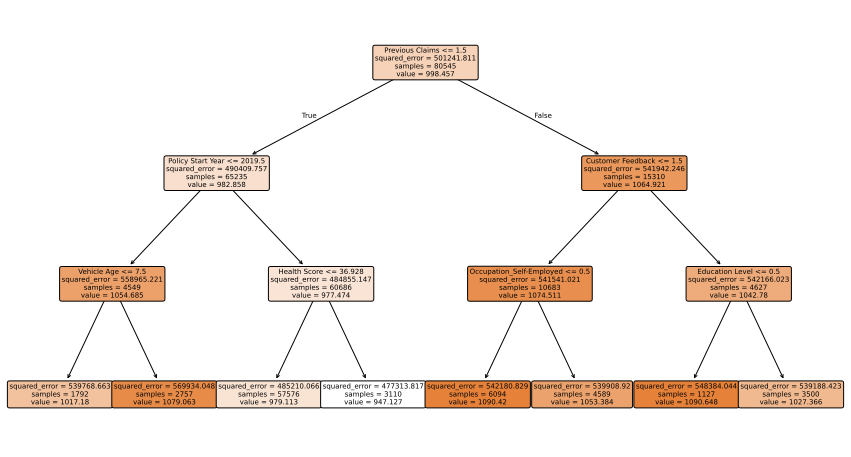

In [15]:
fig = plt.figure(figsize=(15, 8))
plot_tree(dtr_model.model, 
          feature_names=X_train.columns, 
          filled=True, 
          rounded=True, 
          fontsize=7)          
plt.show()

In [16]:
text_representation = export_text(dtr_model.model, feature_names=params["columns_X"])
print(text_representation)

|--- Previous Claims <= 1.50
|   |--- Policy Start Year <= 2019.50
|   |   |--- Vehicle Age <= 7.50
|   |   |   |--- value: [1017.18]
|   |   |--- Vehicle Age >  7.50
|   |   |   |--- value: [1079.06]
|   |--- Policy Start Year >  2019.50
|   |   |--- Health Score <= 36.93
|   |   |   |--- value: [979.11]
|   |   |--- Health Score >  36.93
|   |   |   |--- value: [947.13]
|--- Previous Claims >  1.50
|   |--- Customer Feedback <= 1.50
|   |   |--- Occupation_Self-Employed <= 0.50
|   |   |   |--- value: [1090.42]
|   |   |--- Occupation_Self-Employed >  0.50
|   |   |   |--- value: [1053.38]
|   |--- Customer Feedback >  1.50
|   |   |--- Education Level <= 0.50
|   |   |   |--- value: [1090.65]
|   |   |--- Education Level >  0.50
|   |   |   |--- value: [1027.37]



# SVR

In [17]:
svr_model_name = "SVR"
# Оптимальные параметры из соответствующего ДЗ
svr_best_params={'kernel': 'rbf', 'gamma': 2, 'epsilon': 0.01, 'C': 10}

In [18]:
svr_model = ModelRegression.load_or_create_and_fit_model(svr_model_name, SVR, svr_best_params, 
                                                         X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled,
                                                         settings)

Модель SVR загружена из /home/igel/Projects/ml/ml-inno-hw/3. Machine Learning/3.08. Регрессия Decision Tree/cached_results/04_model_SVR.pickle


In [19]:
svr_model.show_quality()

Train data:
  MSE:    517320.6722
  RMSE:   719.2501
  MAE:    543.7981
  r2:     -0.0321
  median: 833.0
Test data:
  MSE:    534598.2509
  RMSE:   731.1623
  MAE:    555.9256
  r2:     -0.0576
  median: 833.0


# KNNR

In [20]:
knnr_model_name = "KNNR"
# Оптимальные параметры из соответствующего ДЗ
knnr_best_params={'weights': 'uniform', 'p': 1, 'n_neighbors': 18}

In [21]:
knnr_model = ModelRegression.load_or_create_and_fit_model(knnr_model_name, KNeighborsRegressor, knnr_best_params, 
                                                         X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled,
                                                         settings)

Модель KNeighborsRegressor загружена из /home/igel/Projects/ml/ml-inno-hw/3. Machine Learning/3.08. Регрессия Decision Tree/cached_results/04_model_KNNR.pickle


In [22]:
knnr_model.show_quality()

Train data:
  MSE:    471026.9156
  RMSE:   686.314
  MAE:    548.3325
  r2:     0.0603
  median: 833.0
Test data:
  MSE:    535810.975
  RMSE:   731.9911
  MAE:    584.4495
  r2:     -0.06
  median: 833.0


# Сравнительная таблица метрик разных моделей

In [23]:
df_stat = pd.concat([pd.DataFrame(dtr_model.metrics()),
                     pd.DataFrame(dtr_wo_gs_model.metrics()),
                     pd.DataFrame(knnr_model.metrics())
                     ])
columns = ['model_name']
columns = columns + ModelRegression.metrics_names()
df_stat2 = df_stat.pivot_table(columns = 'params',
                            index='model_name',
                            values='values').reset_index()[columns]
df_stat2

params,model_name,Train_MSE,Test_MSE,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_R2,Test_R2,Train_median,Test_Median
0,DT_R,499675.39437,504812.95145,706.87721,710.50190,567.63253,569.48837,0.00313,0.00131,833.00000,833.00000
1,DT_R_WO_GS,0.00000,1080902.95203,0.00000,1039.66483,0.00000,818.74044,1.00000,-1.13840,833.00000,833.00000
2,KNNR,471026.91558,535810.97500,686.31401,731.99110,548.33254,584.44947,0.06028,-0.06002,833.00000,833.00000


Качество модели плохое. R2 близко к нулю, для предсказания целевой переменной использовать нельзя.